# Air flow pressure prediction

The task of this project is to predict ventilator air pressure supplied to patient's lung.


In [101]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
# from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
# from sklearn import feature_selection
# import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor
import pickle
import optuna
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline 
import joblib
# from sklearn.ensemble import AdaBoostRegressor


In [102]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', None)

# Dataset structure

Columns:

`id` - globally-unique time step identifier across an entire file

`breath_id` - globally-unique time step for breaths

`R` - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.

`C` - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.

`time_step` - the actual time stamp.

`u_in` - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.

`u_out` - the control input for the exploratory solenoid valve. Either 0 or 1.

`pressure` - the airway pressure measured in the respiratory circuit, measured in cmH2O.

In [103]:
df = pd.read_csv('train.csv')

In [104]:
df.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


In [106]:
# check for breath_id unique values
df.breath_id.nunique()

75450

Each `breath_id` comprises 80 steps. There are 75450 unique `breath_id` divided into 80 steps each.

In [107]:
# %%script echo skipping
# Detect missing values
df.isna().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64

Missing values is not revealed.

In [108]:
# Generate descriptive statistics
df.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


In [109]:
# remove surplus column
df.drop('id', inplace=True, axis=1)

## Features exploration

In [110]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"


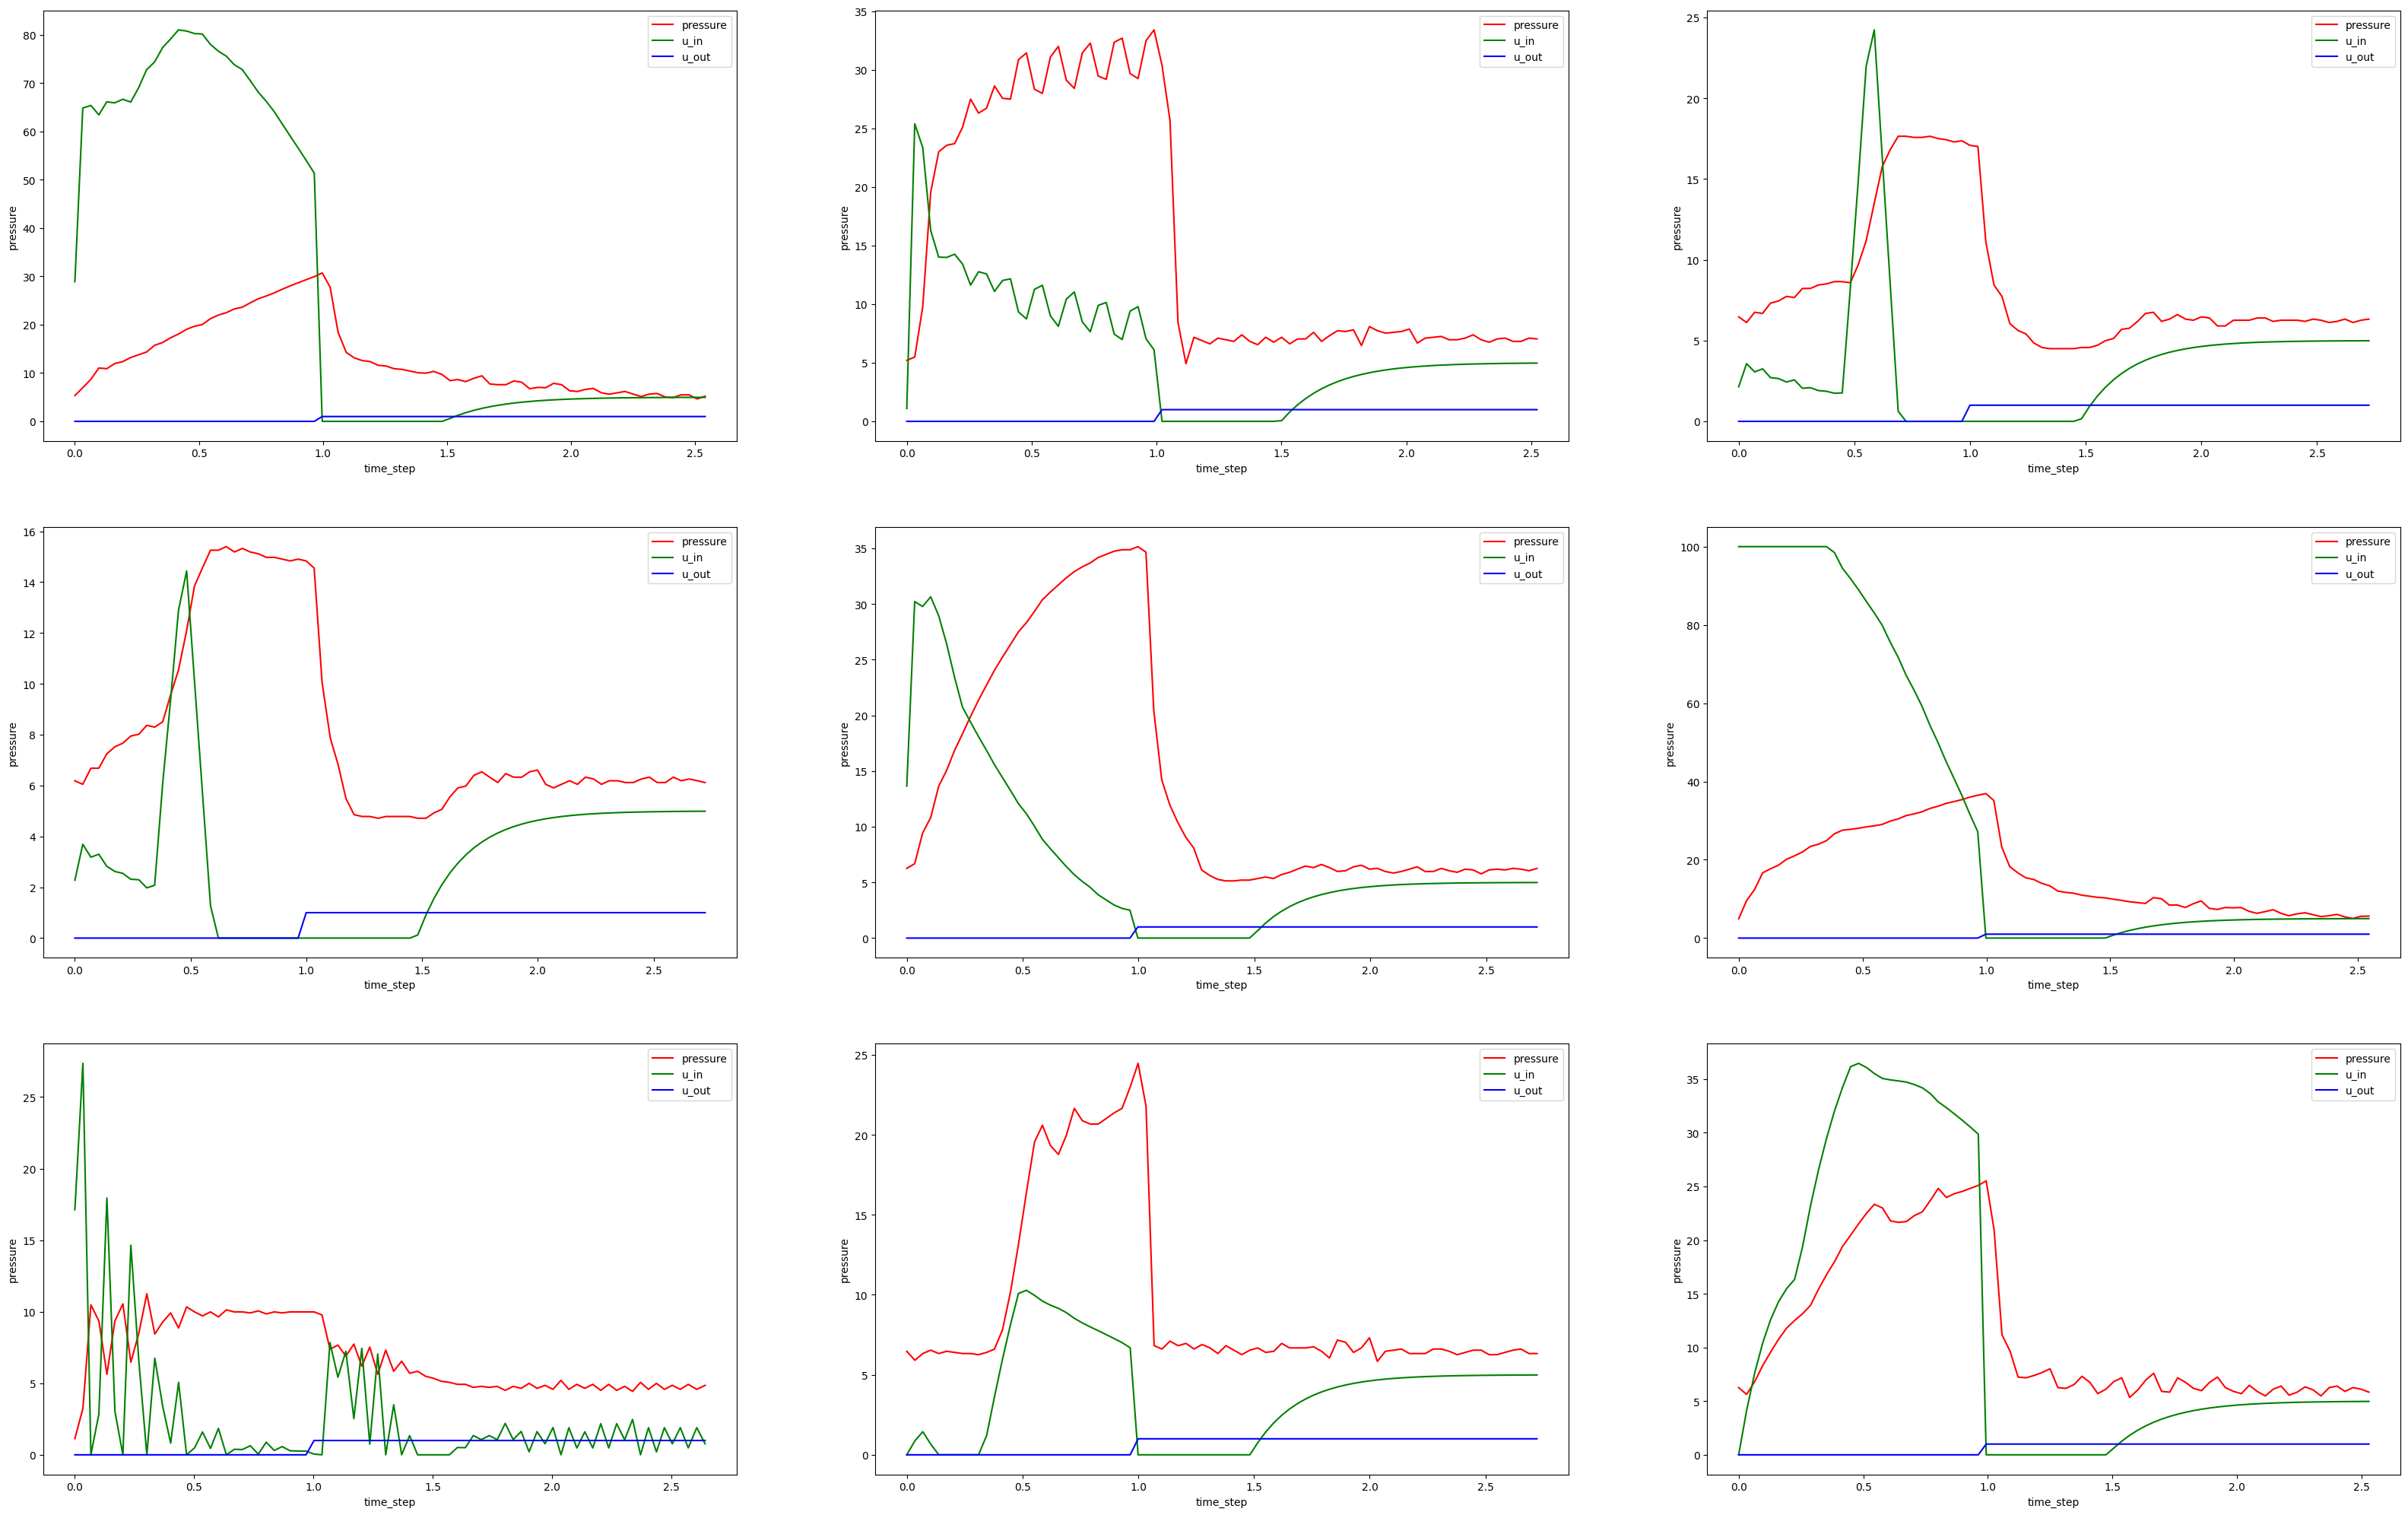

In [111]:
# arbitraty breath_id values 
fig, axes = plt.subplots(3 , 3, figsize=(40, 25))
for i in range(3):
    for j in range(3):
        di = df[df.breath_id == df.sample().breath_id.iloc[0]]
        fig = sns.lineplot(data=di, x='time_step', y='pressure', ax=axes[i][j], color='r', label='pressure')
        sns.lineplot(data=di, x='time_step', y='u_in', ax=axes[i][j], color='g', label='u_in')
        sns.lineplot(data=di, x='time_step', y='u_out', ax=axes[i][j], color='b', label='u_out')
# fig.show()


Pressure values varies very much for different `breath_id` as well as along `time_step` sequence.

In [112]:

InteractiveShell.ast_node_interactivity = "all"

Enumerate `time_step` according to their sequence in column.

In [113]:
df['step'] = 0
for j in range(0, df.breath_id.nunique()):
    df.loc[j * 80:(j * 80 + 79), ['step']] = list(range(1, 81))

In [114]:
# add max and min pressure values for each step
press_max = df.groupby(by='step').pressure.max().reset_index()
press_max.columns = ['step', 'max_pressure']
press_min = df.groupby(by='step').pressure.min().reset_index()
press_min.columns = ['step', 'min_pressure']

In [115]:
df = df.merge(press_max, on='step')
df = df.merge(press_min, on='step')

In [116]:
# %%script echo skipping
# To get real chart uncomment line above. Now it's substituted by it's image.
data = df.groupby('step')[['pressure', 'time_step', 'u_in', 'max_pressure', 'min_pressure']].agg({'pressure':'mean', 'time_step':'mean', 'max_pressure':'max', 'min_pressure':'min'})
fig = px.line(data, 
              x='time_step', 
              y=['pressure', 'max_pressure', 'min_pressure'], 
              title='pressure vs step', labels=dict(y='pressure')).for_each_trace(
    lambda t: t.update(fill="tonexty", fillcolor='rgba(26,150,65,0.2)')
    if t.name == "max_pressure" or t.name == 'min_pressure'
    else t
).update_traces()
fig.show()

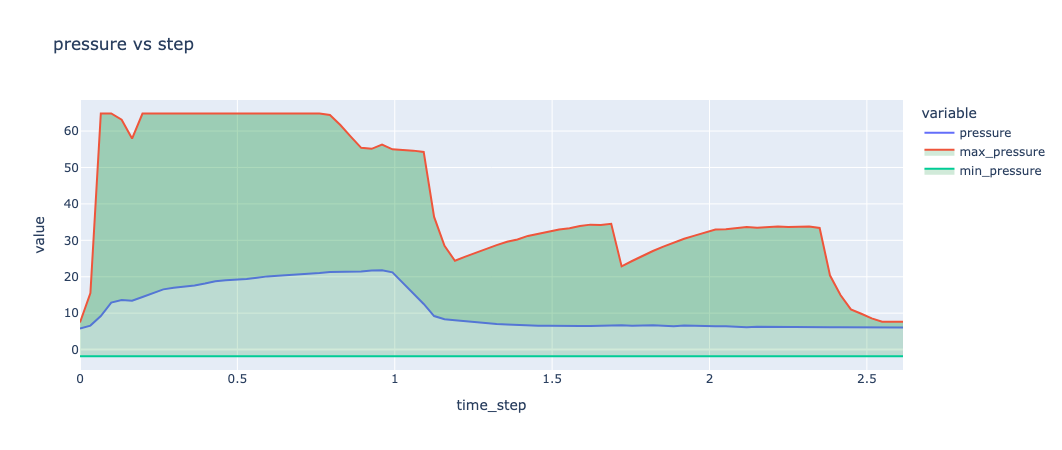

For each `time_step` min and max `pressure` varies very much. 

Let's narrow it by taking into consideration features `R` and `C`.

In [117]:
# For example take R == 5 & C == 20
data = df.groupby(['step', 'R', 'C']).pressure.agg(['min', 'max', 'mean']).reset_index()
fig = px.scatter(data[(data.R == 5) & (data.C == 20)], 
              x='step', 
              y=['min', 'max', 'mean'], 
              title=f'pressure vs step for R = {5} and C= {20}').update_traces()
fig.show()

Even within uniform parameters `pressure` differs significantly.

In [118]:
# Some distribution pressure for arbitrary set of parameters
fig5 = make_subplots(rows = 2,cols = 2)
fig5.append_trace(go.Histogram(x=df[(df.R == 5) & (df.C == 10) & (df.step == 1)].pressure, name='R=5 , C=10, step=1'),row=1,col=1)
fig5.append_trace(go.Histogram(x=df[(df.R == 50) & (df.C == 50) & (df.step == 78)].pressure, name='R=50 , C=50, step=78'),row=1,col=2)
fig5.append_trace(go.Histogram(x=df[(df.R == 5) & (df.C == 10) & (df.step == 78)].pressure, name='R=5 , C=10, step=78'),row=2,col=1)
fig5.append_trace(go.Histogram(x=df[(df.R == 20) & (df.C == 20) & (df.step == 50)].pressure, name='R=20 , C=20, step=50'),row=2,col=2)
fig5.update_layout(height = 600,width = 800,title = "Pressure distribution with various set of <b>R</b> and <b>C</b> parameters", bargap=0.08, legend_title='Some features values')

With this specific problem data distribution it is hardly possible to judge which of the data are outliers and not the valid one. 

Nevertheless let's conduct check for normality of pressure distribution for unique sets of parameters.

In [119]:
import scipy.stats as stats
alpha = 0.05
not_normal = 0
normal = 0

for step, r, c in df.groupby(['step', 'R', 'C']).pressure.mean().index:
    data_i = df[(df.R == r) & (df.C == c) & (df.step == step)].pressure

    _, p = stats.shapiro(data_i)

    if p <= alpha:
        not_normal += 1
    else:
        normal += 1

print(f'count of normal pressure distributions: {normal}')
print(f'count of not normal pressure distributions: {not_normal}')

count of normal pressure distributions: 0
count of not normal pressure distributions: 720


There is no one normal pressure destribution for every unique set of parameters. It is unreasonable to look for outliers in given dataset.

In [120]:
%%script echo skipping
# To get real chart uncomment line above. Now it's substituted by it's image.
px.histogram(df, x='pressure', histfunc='count', title='pressure distribution')

skipping


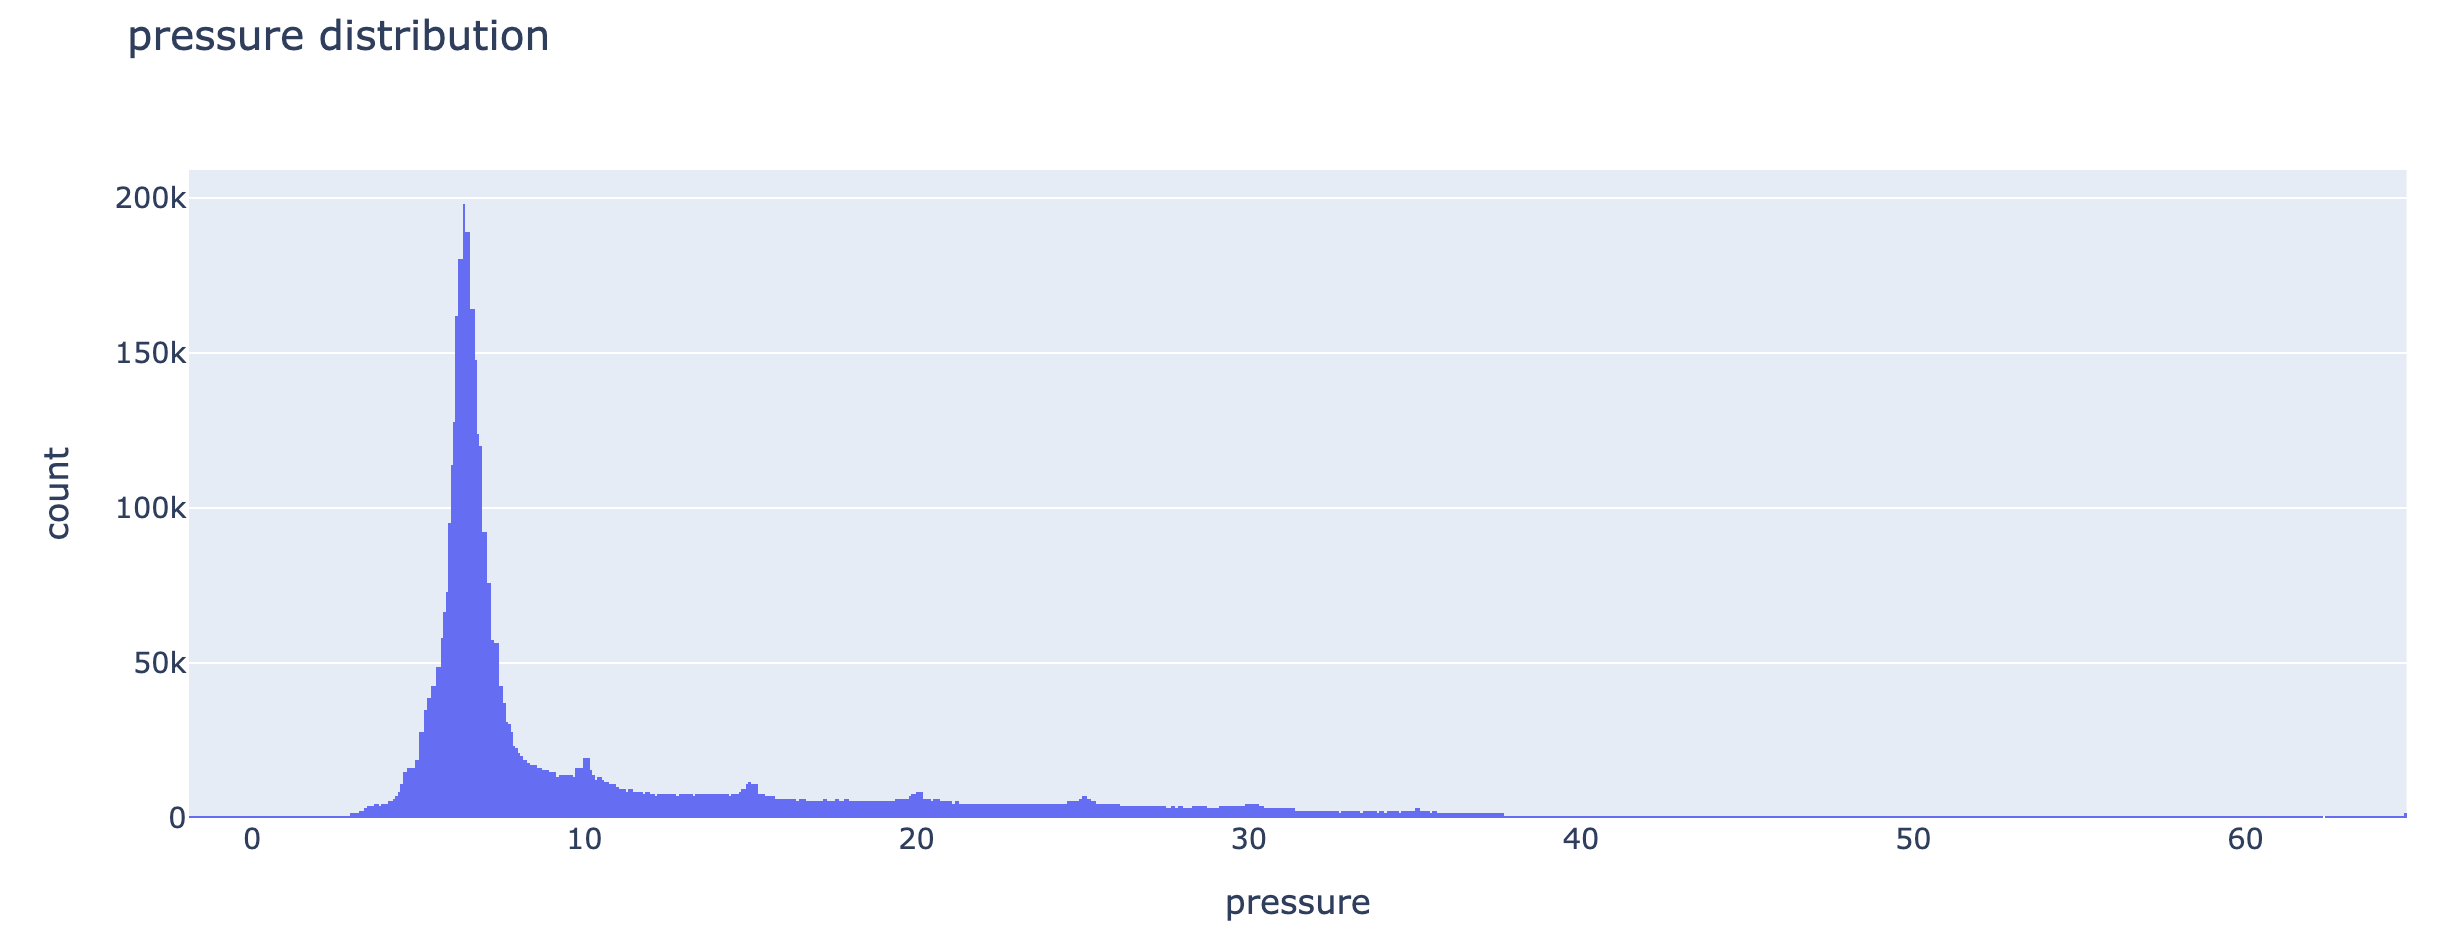

In [121]:
%%script echo skipping
# To get real chart uncomment line above. Now it's substituted by it's image.
px.histogram(df, x='time_step', y='pressure', histfunc='avg', title='Average pressure over time_step')

skipping


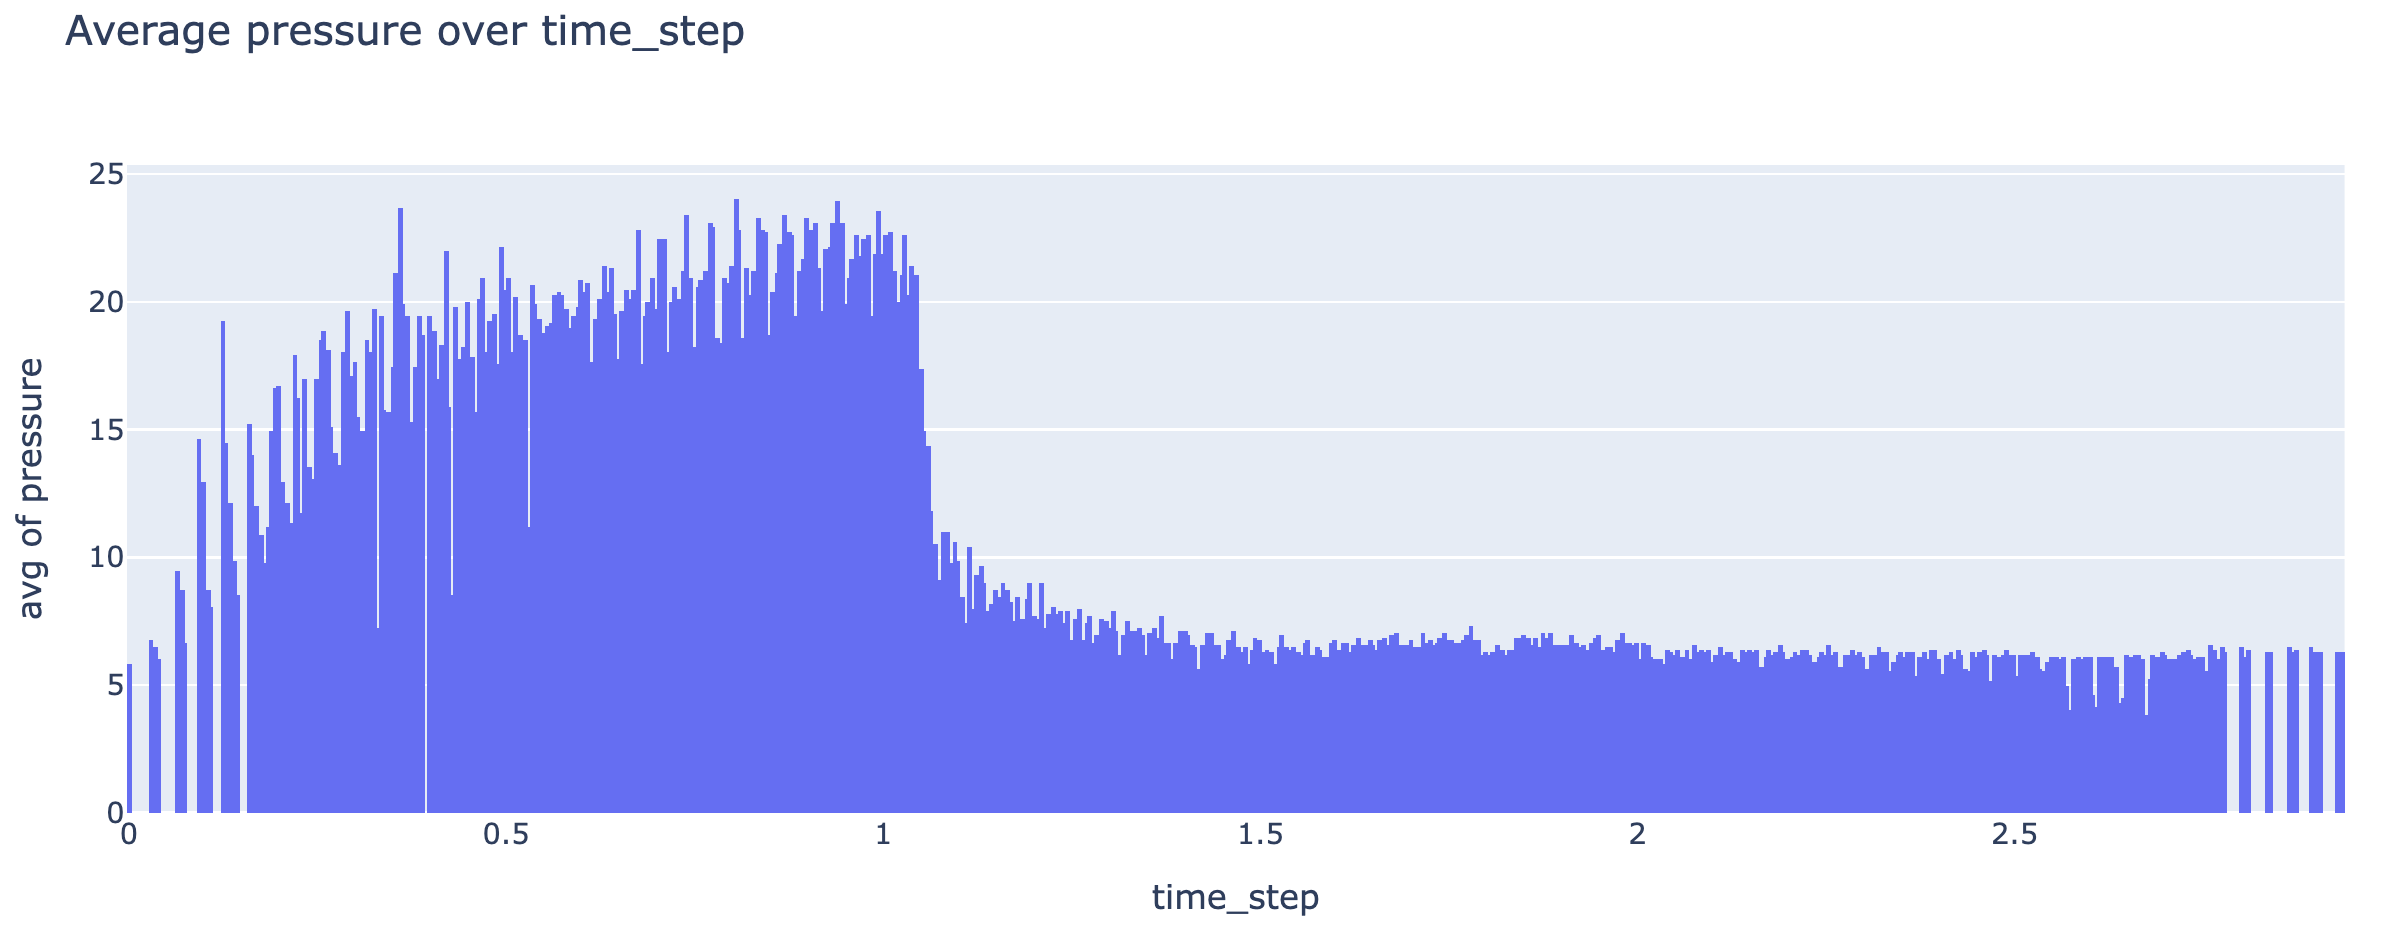

In [122]:
%%script echo skipping
# To get real chart uncomment line above. Now it's substituted by it's image.
fig = px.histogram(df, x='u_in', y='pressure', histfunc='avg', title='u_in vs time_step')
fig.update_layout(bargap=0.2)


skipping


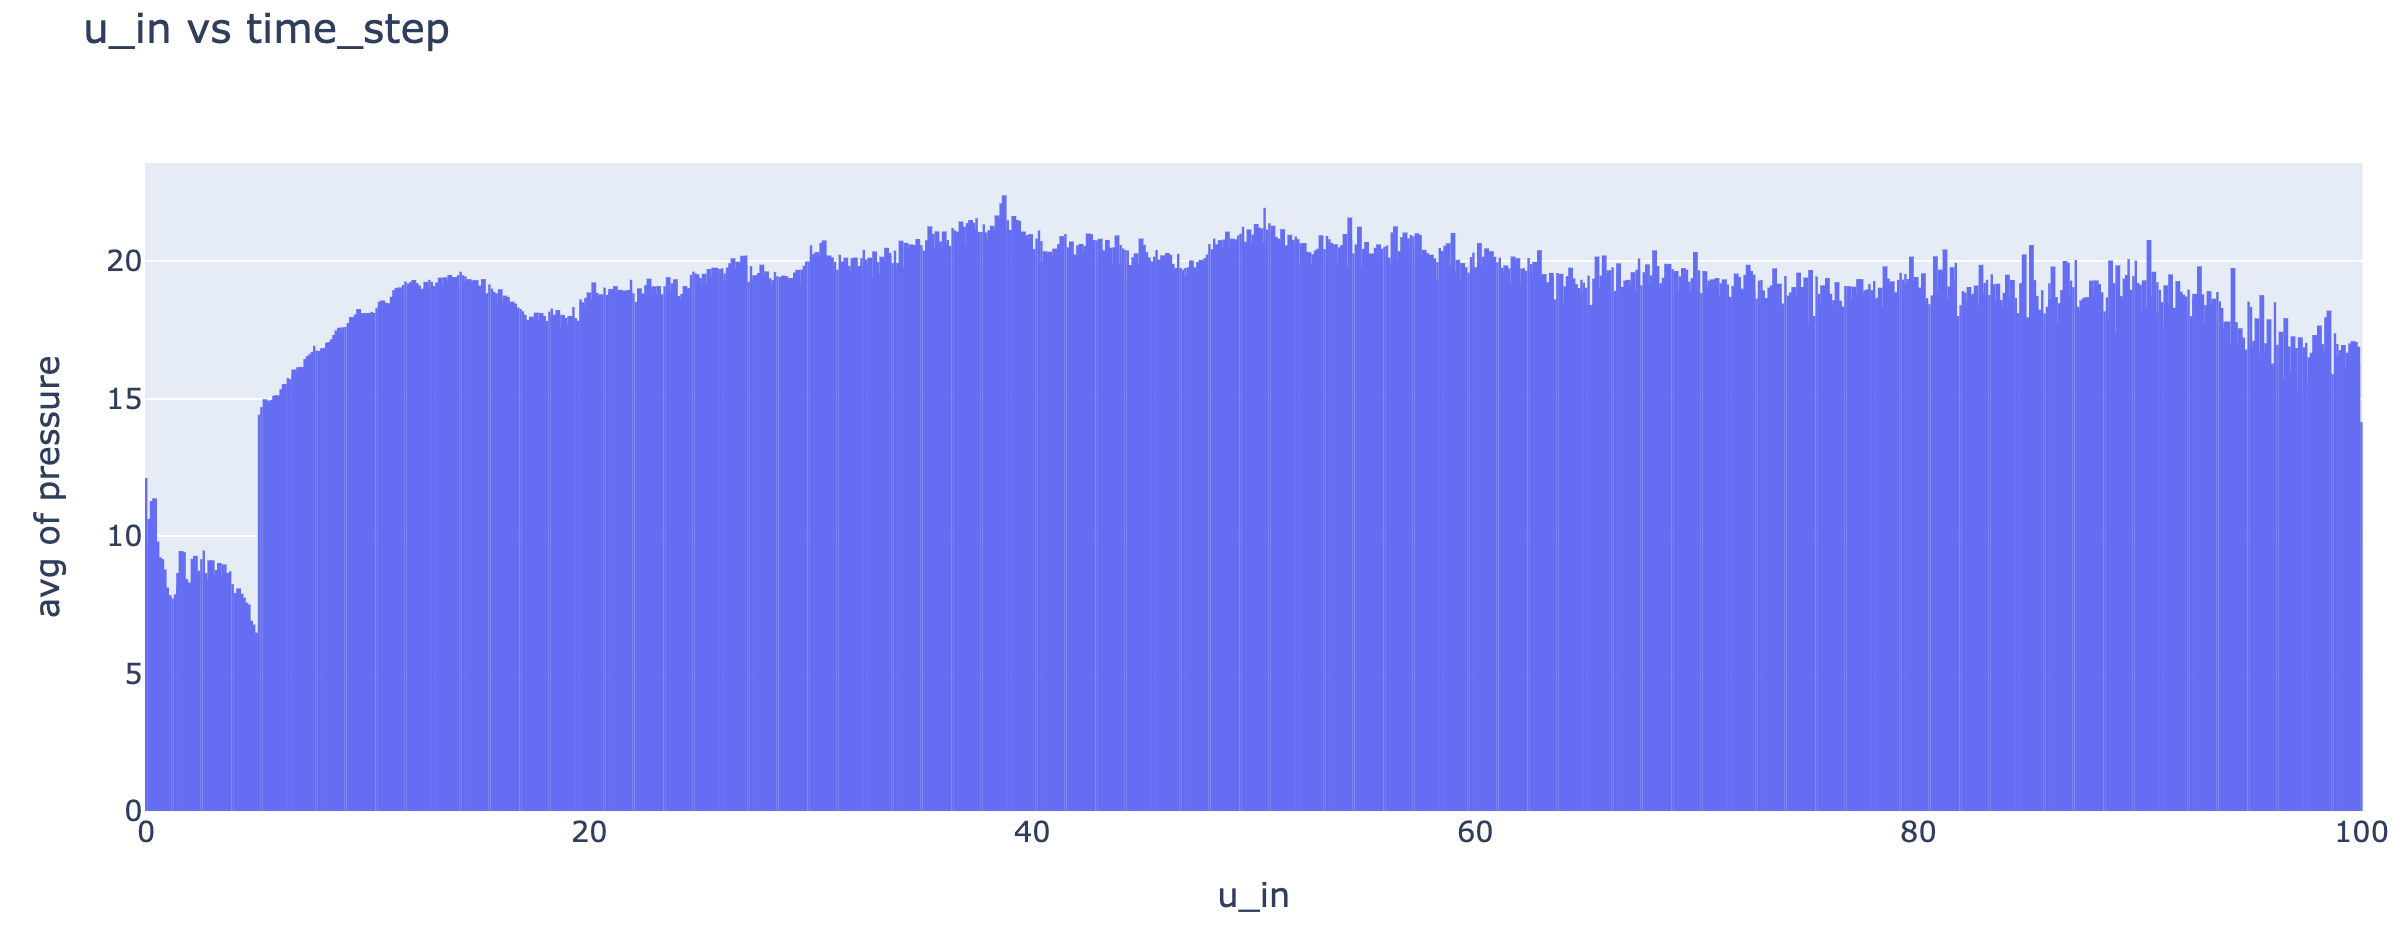

# Metrics

For metrics choose mean absolute error and mean absolute precentage error. Mean absolute error is not very much informative considering the problem, becouse it's difficult to evaluate how much error will influence breath process wereas mean absolute percentage error gives understanding about deviation from the true required value.

Function for calculating and storing metric's values.

In [123]:
results = []
def metrics_values(y_train_true, y_train_pred, y_test_true, y_test_pred, name, param=None):
    dic = dict(name = name, 
        Train_MAPE = (metrics.mean_absolute_percentage_error(y_train_true, y_train_pred)*100),
        Test_MAPE = (metrics.mean_absolute_percentage_error(y_test_true, y_test_pred)*100),
        Train_MAE = (metrics.mean_absolute_error(y_train_true, y_train_pred)),
        Test_MAE = (metrics.mean_absolute_error(y_test_true, y_test_pred))) 
    if param:
        dic['param'] = param
    results.append(dic)      
    
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train_true, y_train_pred)*100))
    print('Test MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test_true, y_test_pred)*100))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train_true, y_train_pred)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test_true, y_test_pred)))


In [124]:
def show_results_df():
    train_mape = []
    test_mape = []
    train_mae = []
    test_mae = []
    name = []
    param = []

    for i in results:
        if i['Train_MAPE']:
            train_mape.append(i['Train_MAPE'])
        if i['Test_MAPE']:
            test_mape.append(i['Test_MAPE'])
        if i['Train_MAE']:
            train_mae.append(i['Train_MAE'])
        if i['Test_MAE']:
            test_mae.append(i['Test_MAE'])
        if i['name']:
            name.append(i['name'])
        if i['param']:
            param.append(i['param'])
        
    result_df = pd.DataFrame({'Train_MAPE':train_mape,
                            'Test_MAPE':test_mape,
                            'Train_MAE':train_mape,
                            'Test_MAE':test_mae,
                            'name':name,
                            'param':param})
    return result_df

In [125]:
pd.set_option('display.max_colwidth', None)
show_results_df().sort_values('Test_MAE', ascending=True)

,Train_MAPE,Test_MAPE,Train_MAE,Test_MAE,name,param


In [126]:
# Function for metric data presentation

def show_results(rnd=3):
    lenght = 0
    for ind, val in enumerate(results):
        if len(val['name']) > lenght:
            lenght = len(val['name'])
    
    if rnd > 0:
        for ind, val in enumerate(results):
            
            if ind == 0:
                print('{:>{}}\t{:<12}\t{:<12}\t{:<12}'.format('Train MAPE', lenght + len('Train MAPE') + 5, 
                                                              'Test MAPE', #cnt + 4, 
                                                              'Train MAE', #cnt + 4, 
                                                              'Test MAE'))
            print('{}. {:<{}}: {:<12}\t{:<12}\t{:<12}\t{:<12}'.format(ind + 1, 
                                                                      val['name'], lenght, 
                                                                      round(val['Train_MAPE'], rnd), #cnt + 4,
                                                                      round(val['Test_MAPE'],  rnd), #cnt + 4,
                                                                      round(val['Train_MAE'], rnd), #cnt + 4,
                                                                      round(val['Test_MAE'], rnd)))
            if 'param' in val: 
                if type(val['param']) is str:
                    lst = val['param'].split('\n')
                    for k, v in enumerate(lst):
                        print('\t', lst[k])
                else: print('\t', val['param'])
                    
    else:
        for ind, val in enumerate(results):
            if ind == 0:
                print('{:>{}}\t\t{:<18}\t{:<18}\t{:<18}'.format('Train MAPE', lenght + len('Train MAPE') + 5, 
                                                              'Test MAPE', 
                                                              'Train MAE', 
                                                              'Test MAE'))
            print('{}. {:<{}}: {:<22}\t{:<18}\t{:<18}\t{:<18}'.format(ind + 1, 
                                                                      val['name'], lenght, 
                                                                      val['Train_MAPE'], 
                                                                      val['Test_MAPE'], 
                                                                      val['Train_MAE'], 
                                                                      val['Test_MAE']))
            if 'param' in val: 
                if type(val['param']) is str:
                    lst = val['param'].split('\n')
                    for k, v in enumerate(lst):
                        print('\t', lst[k])
                else: print('\t', val['param'])

In [127]:
%%script true
# in case of need load previous metric results
with open('all_results.pkl', 'rb') as pkl_file:
    result = pickle.load(pkl_file)

In [128]:
%%script true
# in case of nees save metric results to file
with open('all_results.pkl', 'wb') as output:
    pickle.dump(results, output)

In [129]:
# remove auxiliary features
df.drop(['step', 'max_pressure', 'min_pressure'], axis=1, inplace=True)

# Linear regression

For baseline consider linear regression.

In [130]:
X = df.drop(['breath_id', 'pressure', ], axis=1)
y = df.pressure
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

In [33]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)


metrics_values(y_train, y_train_pred, y_test, y_test_pred, 'linear regression', param=lr.get_params())

LinearRegression()

Train MAPE: 48.859
Test MAPE: 51.714
Train MAE: 3.946
Test MAE: 3.955


Result doesn't look acceptable.

## Polynomial linear regression

Try linear regression with polynomial features.

In [34]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
# Scaling
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


MinMaxScaler()

In [35]:
# turn to logarithm representation. Some pressure values are negative but no less than -2. That's why added 2.
y_train_log = np.log(y_train + 2)

In [36]:
# adding polynomial features
poly = preprocessing.PolynomialFeatures(degree=6, include_bias=False)
poly.fit(X_train_scaled)
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

PolynomialFeatures(degree=6, include_bias=False)

In [37]:
lr = linear_model.LinearRegression()
lr.fit(X_train_scaled_poly, y_train_log)
# switching back from logarighm representation
y_train_pred = np.exp(lr.predict(X_train_scaled_poly)) - 2
y_test_pred = np.exp(lr.predict(X_test_scaled_poly)) - 2

metrics_values(y_train, y_train_pred, y_test, y_test_pred, 
               'LinearRegression', 
               'PolynomialFeatures{}'.format(poly.get_params()))

LinearRegression()

Train MAPE: 27.294
Test MAPE: 28.819
Train MAE: 2.307
Test MAE: 2.315


In [38]:
show_results()

                      Train MAPE	Test MAPE   	Train MAE   	Test MAE    
1. linear regression: 48.859      	51.714      	3.946       	3.955       
	 {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
2. LinearRegression : 27.294      	28.819      	2.307       	2.315       
	 PolynomialFeatures{'degree': 6, 'include_bias': False, 'interaction_only': False, 'order': 'C'}


Metrics have improved but still not satisfying.

## Ridge

Try ridge.

In [39]:
ridge_lr_poly = linear_model.Ridge(alpha=0.001, max_iter=10000)
ridge_lr_poly.fit(X_train_scaled_poly, y_train_log)

y_train_pred = np.exp(ridge_lr_poly.predict(X_train_scaled_poly))
y_test_pred = np.exp(ridge_lr_poly.predict(X_test_scaled_poly))

metrics_values(y_train, y_train_pred, y_test, y_test_pred, 
               'Ridge', 
               param='Ridge{}\nPolynomialFeatures{}'.format(ridge_lr_poly.get_params(), poly.get_params()))

Ridge(alpha=0.001, max_iter=10000)

Train MAPE: 46.749
Test MAPE: 48.657
Train MAE: 3.365
Test MAE: 3.371


In [40]:
show_results()

                      Train MAPE	Test MAPE   	Train MAE   	Test MAE    
1. linear regression: 48.859      	51.714      	3.946       	3.955       
	 {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
2. LinearRegression : 27.294      	28.819      	2.307       	2.315       
	 PolynomialFeatures{'degree': 6, 'include_bias': False, 'interaction_only': False, 'order': 'C'}
3. Ridge            : 46.749      	48.657      	3.365       	3.371       
	 Ridge{'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'max_iter': 10000, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}
	 PolynomialFeatures{'degree': 6, 'include_bias': False, 'interaction_only': False, 'order': 'C'}


Metrics became even worser.

# RandomForestRegressor

In [41]:
rf = RandomForestRegressor(max_depth=10, n_estimators=10, n_jobs=-1) 
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

metrics_values(y_train, y_train_pred, y_test, y_test_pred, 
               'RandomForestRegressor',
               param='RFRegressor{}'.format(rf.get_params())
               )

RandomForestRegressor(max_depth=10, n_estimators=10, n_jobs=-1)

Train MAPE: 27.124
Test MAPE: 29.403
Train MAE: 2.099
Test MAE: 2.107


In [42]:
# del results[3]
show_results()

                          Train MAPE	Test MAPE   	Train MAE   	Test MAE    
1. linear regression    : 48.859      	51.714      	3.946       	3.955       
	 {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
2. LinearRegression     : 27.294      	28.819      	2.307       	2.315       
	 PolynomialFeatures{'degree': 6, 'include_bias': False, 'interaction_only': False, 'order': 'C'}
3. Ridge                : 46.749      	48.657      	3.365       	3.371       
	 Ridge{'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'max_iter': 10000, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}
	 PolynomialFeatures{'degree': 6, 'include_bias': False, 'interaction_only': False, 'order': 'C'}
4. RandomForestRegressor: 27.124      	29.403      	2.099       	2.107       
	 RFRegressor{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decre

Result is nearly twice better comparing to linear regression.

# Feature Engineering



In [131]:
time_step_max = df.groupby('breath_id').time_step.idxmax()
time_step_max.head()

breath_id
1     79
2    159
3    239
4    319
5    399
Name: time_step, dtype: int64

In [132]:
# u_in correspondent to time_step_max
last_u_in = df.loc[time_step_max, ['breath_id','u_in']]
last_u_in.head()

,breath_id,u_in
79,1,4.987079
159,2,4.988518
239,3,4.970562
319,4,4.971585
399,5,4.990306


In [133]:
# add feature last_u_in
last_u_in.rename(columns={'u_in':'last_u_in'}, inplace=True)
df = df.merge(last_u_in, on='breath_id')
df.head()

,breath_id,R,C,time_step,u_in,u_out,pressure,last_u_in
0,1,20,50,0.000000,0.083334,0,5.837492,4.987079
1,1,20,50,0.033652,18.383041,0,5.907794,4.987079
2,1,20,50,0.067514,22.509278,0,7.876254,4.987079
3,1,20,50,0.101542,22.808822,0,11.742872,4.987079
4,1,20,50,0.135756,25.355850,0,12.234987,4.987079


In [134]:
# add feature mean u_in
mean_u_in = df.groupby('breath_id')['u_in'].mean().to_frame()
mean_u_in.rename(columns={'u_in':'mean_u_in'}, inplace=True)
df = df.merge(mean_u_in, on='breath_id')

In [135]:
df['diff_u_in'] = df.groupby('breath_id')['u_in'].diff()
df = df.fillna(0)
df.head()

,breath_id,R,C,time_step,u_in,u_out,pressure,last_u_in,mean_u_in,diff_u_in
0,1,20,50,0.000000,0.083334,0,5.837492,4.987079,10.146007,0.000000
1,1,20,50,0.033652,18.383041,0,5.907794,4.987079,10.146007,18.299707
2,1,20,50,0.067514,22.509278,0,7.876254,4.987079,10.146007,4.126236
3,1,20,50,0.101542,22.808822,0,11.742872,4.987079,10.146007,0.299544
4,1,20,50,0.135756,25.355850,0,12.234987,4.987079,10.146007,2.547028


In [136]:
df['diff2_u_in'] = df.groupby('breath_id')['diff_u_in'].diff()
df = df.fillna(0)
df.head()

,breath_id,R,C,time_step,u_in,u_out,pressure,last_u_in,mean_u_in,diff_u_in,diff2_u_in
0,1,20,50,0.000000,0.083334,0,5.837492,4.987079,10.146007,0.000000,0.000000
1,1,20,50,0.033652,18.383041,0,5.907794,4.987079,10.146007,18.299707,18.299707
2,1,20,50,0.067514,22.509278,0,7.876254,4.987079,10.146007,4.126236,-14.173471
3,1,20,50,0.101542,22.808822,0,11.742872,4.987079,10.146007,0.299544,-3.826692
4,1,20,50,0.135756,25.355850,0,12.234987,4.987079,10.146007,2.547028,2.247484


In [137]:
# add feature for comsum of u_in
df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()

In [138]:
#add feature sum value u_in
sum_u_in = df.groupby('breath_id')['u_in'].sum().to_frame()
sum_u_in.columns = ['sum_value_u_in']
df = df.merge(sum_u_in,on='breath_id')
df.head()

,breath_id,R,C,time_step,u_in,u_out,pressure,last_u_in,mean_u_in,diff_u_in,diff2_u_in,u_in_cumsum,sum_value_u_in
0,1,20,50,0.000000,0.083334,0,5.837492,4.987079,10.146007,0.000000,0.000000,0.083334,811.680524
1,1,20,50,0.033652,18.383041,0,5.907794,4.987079,10.146007,18.299707,18.299707,18.466375,811.680524
2,1,20,50,0.067514,22.509278,0,7.876254,4.987079,10.146007,4.126236,-14.173471,40.975653,811.680524
3,1,20,50,0.101542,22.808822,0,11.742872,4.987079,10.146007,0.299544,-3.826692,63.784476,811.680524
4,1,20,50,0.135756,25.355850,0,12.234987,4.987079,10.146007,2.547028,2.247484,89.140326,811.680524


In [139]:
#add feature u_in_cumsum_rate
df["u_in_cumsum_rate"] = df["u_in_cumsum"] / df["sum_value_u_in"]

In [140]:
df.isna().sum()

breath_id              0
R                      0
C                      0
time_step              0
u_in                   0
u_out                  0
pressure               0
last_u_in              0
mean_u_in              0
diff_u_in              0
diff2_u_in             0
u_in_cumsum            0
sum_value_u_in         0
u_in_cumsum_rate    1120
dtype: int64

In [141]:
df = df.fillna(0)

In [142]:
#add feature: lag of u_in
df['lag_u_in'] = df.groupby('breath_id')['u_in'].shift(1)
df = df.fillna(0)

#add feature: lag2 of u_in
df['lag_2_u_in'] = df.groupby('breath_id')['u_in'].shift(2)
df = df.fillna(0)

In [143]:
#add feature lag -1 and -2 u_in
df['lag_-1_u_in'] = df.groupby('breath_id')['u_in'].shift(-1)
df = df.fillna(0)

df['lag_-2_u_in'] = df.groupby('breath_id')['u_in'].shift(-2)
df = df.fillna(0)

In [144]:
#add feature lag -3 and 3 u_in
df['lag_-3_u_in'] = df.groupby('breath_id')['u_in'].shift(-3)
df = df.fillna(0)

df['lag_3_u_in'] = df.groupby('breath_id')['u_in'].shift(3)
df = df.fillna(0)

In [145]:
#add feature: max_u_in_breathid
df["max_u_in_breathid"] = df.groupby("breath_id")["u_in"].transform("max")

#add feature: R*C
df["R*C"] = df['R'] * df['C']

## add breath_id__u_in__min
df['breath_id__u_in__min'] = df.groupby(['breath_id'])['u_in'].transform('min')

## add breath_id__u_in__diffmax & breath_id__u_in__diffmean
df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']

df['u_in_partition_out_sum'] = df.groupby(['breath_id',"u_out"])['u_in'].transform("sum")

##add feature area
df['area'] = df['time_step'] * df['u_in']
df['area'] = df.groupby('breath_id')['area'].cumsum()

In [146]:
# df = pd.get_dummies(df,columns=["R_C"])
df.columns

Index(['breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure',
       'last_u_in', 'mean_u_in', 'diff_u_in', 'diff2_u_in', 'u_in_cumsum',
       'sum_value_u_in', 'u_in_cumsum_rate', 'lag_u_in', 'lag_2_u_in',
       'lag_-1_u_in', 'lag_-2_u_in', 'lag_-3_u_in', 'lag_3_u_in',
       'max_u_in_breathid', 'R*C', 'breath_id__u_in__min',
       'breath_id__u_in__diffmax', 'breath_id__u_in__diffmean',
       'u_in_partition_out_sum', 'area'],
      dtype='object')

In [147]:
##add feaure time_diff
df['time_diff']=df.time_step.diff().fillna(0)

In [148]:
df.head()

,breath_id,R,C,time_step,u_in,u_out,pressure,last_u_in,mean_u_in,diff_u_in,diff2_u_in,u_in_cumsum,sum_value_u_in,u_in_cumsum_rate,lag_u_in,lag_2_u_in,lag_-1_u_in,lag_-2_u_in,lag_-3_u_in,lag_3_u_in,max_u_in_breathid,R*C,breath_id__u_in__min,breath_id__u_in__diffmax,breath_id__u_in__diffmean,u_in_partition_out_sum,area,time_diff
0,1,20,50,0.000000,0.083334,0,5.837492,4.987079,10.146007,0.000000,0.000000,0.083334,811.680524,0.000103,0.000000,0.000000,18.383041,22.509278,22.808822,0.000000,28.313036,1000,0.0,28.229702,10.062673,663.594727,0.000000,0.000000
1,1,20,50,0.033652,18.383041,0,5.907794,4.987079,10.146007,18.299707,18.299707,18.466375,811.680524,0.022751,0.083334,0.000000,22.509278,22.808822,25.355850,0.000000,28.313036,1000,0.0,9.929994,-8.237035,663.594727,0.618632,0.033652
2,1,20,50,0.067514,22.509278,0,7.876254,4.987079,10.146007,4.126236,-14.173471,40.975653,811.680524,0.050482,18.383041,0.083334,22.808822,25.355850,27.259866,0.000000,28.313036,1000,0.0,5.803758,-12.363271,663.594727,2.138333,0.033862
3,1,20,50,0.101542,22.808822,0,11.742872,4.987079,10.146007,0.299544,-3.826692,63.784476,811.680524,0.078583,22.509278,18.383041,25.355850,27.259866,27.127486,0.083334,28.313036,1000,0.0,5.504214,-12.662816,663.594727,4.454391,0.034028
4,1,20,50,0.135756,25.355850,0,12.234987,4.987079,10.146007,2.547028,2.247484,89.140326,811.680524,0.109822,22.808822,22.509278,27.259866,27.127486,26.807732,18.383041,28.313036,1000,0.0,2.957185,-15.209844,663.594727,7.896588,0.034213


In [149]:
df.describe()

,breath_id,R,C,time_step,u_in,u_out,pressure,last_u_in,mean_u_in,diff_u_in,diff2_u_in,u_in_cumsum,sum_value_u_in,u_in_cumsum_rate,lag_u_in,lag_2_u_in,lag_-1_u_in,lag_-2_u_in,lag_-3_u_in,lag_3_u_in,max_u_in_breathid,R*C,breath_id__u_in__min,breath_id__u_in__diffmax,breath_id__u_in__diffmean,u_in_partition_out_sum,area,time_diff
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01,4.708053e+00,7.321615e+00,-1.150328e-01,3.370121e-05,4.062300e+02,5.857292e+02,6.248446e-01,7.262764e+00,7.203947e+00,7.147731e+00,6.797571e+00,6.508529e+00,7.145212e+00,3.602008e+01,6.728330e+02,1.716758e-02,2.869846e+01,3.635116e-18,2.574500e+02,1.939387e+02,4.370473e-07
std,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00,9.924053e-01,5.499683e+00,7.284356e+00,1.100220e+01,4.141439e+02,4.399747e+02,2.773040e-01,1.345586e+01,1.347672e+01,1.314116e+01,1.242073e+01,1.193367e+01,1.349727e+01,3.140594e+01,7.166165e+02,1.168396e-01,3.045699e+01,1.225743e+01,3.059905e+02,2.074166e+02,2.943501e-01
min,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00,0.000000e+00,0.000000e+00,-1.000000e+02,-1.974470e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+01,0.000000e+00,0.000000e+00,-9.602704e+01,0.000000e+00,0.000000e+00,-2.937238e+00
25%,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00,4.970660e+00,3.678580e+00,0.000000e+00,-4.280417e-02,1.349007e+02,2.942864e+02,4.291926e-01,8.853319e-03,0.000000e+00,1.241114e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.138441e+01,2.000000e+02,0.000000e+00,5.387600e+00,-1.720140e+00,1.336787e+02,4.040059e+01,3.188229e-02
50%,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00,4.975697e+00,5.460786e+00,6.602220e-03,-1.839803e-03,2.755448e+02,4.368629e+02,6.853960e-01,4.296469e+00,4.193605e+00,4.344646e+00,4.275508e+00,4.194037e+00,4.074383e+00,2.365779e+01,5.000000e+02,0.000000e+00,1.639117e+01,1.505130e+00,1.492018e+02,1.253416e+02,3.342915e-02
75%,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01,4.988696e+00,8.838124e+00,1.473208e-01,0.000000e+00,5.147282e+02,7.070499e+02,8.598265e-01,4.980925e+00,4.977415e+00,4.981339e+00,4.976431e+00,4.972010e+00,4.973260e+00,5.287211e+01,1.000000e+03,0.000000e+00,4.159759e+01,4.997646e+00,2.194001e+02,2.830377e+02,3.404236e-02
max,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01,5.186653e+00,3.404945e+01,1.000000e+02,1.716481e+02,2.723956e+03,2.723956e+03,1.000000e+00,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,2.500000e+03,1.171243e+00,1.000000e+02,3.404945e+01,2.587574e+03,1.717612e+03,2.510931e-01


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 28 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   breath_id                  int64  
 1   R                          int64  
 2   C                          int64  
 3   time_step                  float64
 4   u_in                       float64
 5   u_out                      int64  
 6   pressure                   float64
 7   last_u_in                  float64
 8   mean_u_in                  float64
 9   diff_u_in                  float64
 10  diff2_u_in                 float64
 11  u_in_cumsum                float64
 12  sum_value_u_in             float64
 13  u_in_cumsum_rate           float64
 14  lag_u_in                   float64
 15  lag_2_u_in                 float64
 16  lag_-1_u_in                float64
 17  lag_-2_u_in                float64
 18  lag_-3_u_in                float64
 19  lag_3_u_in                 float64
 20  ma

# Correlation matrix

In [63]:
cor_matrix = df.corr()

<Figure size 2500x2500 with 0 Axes>

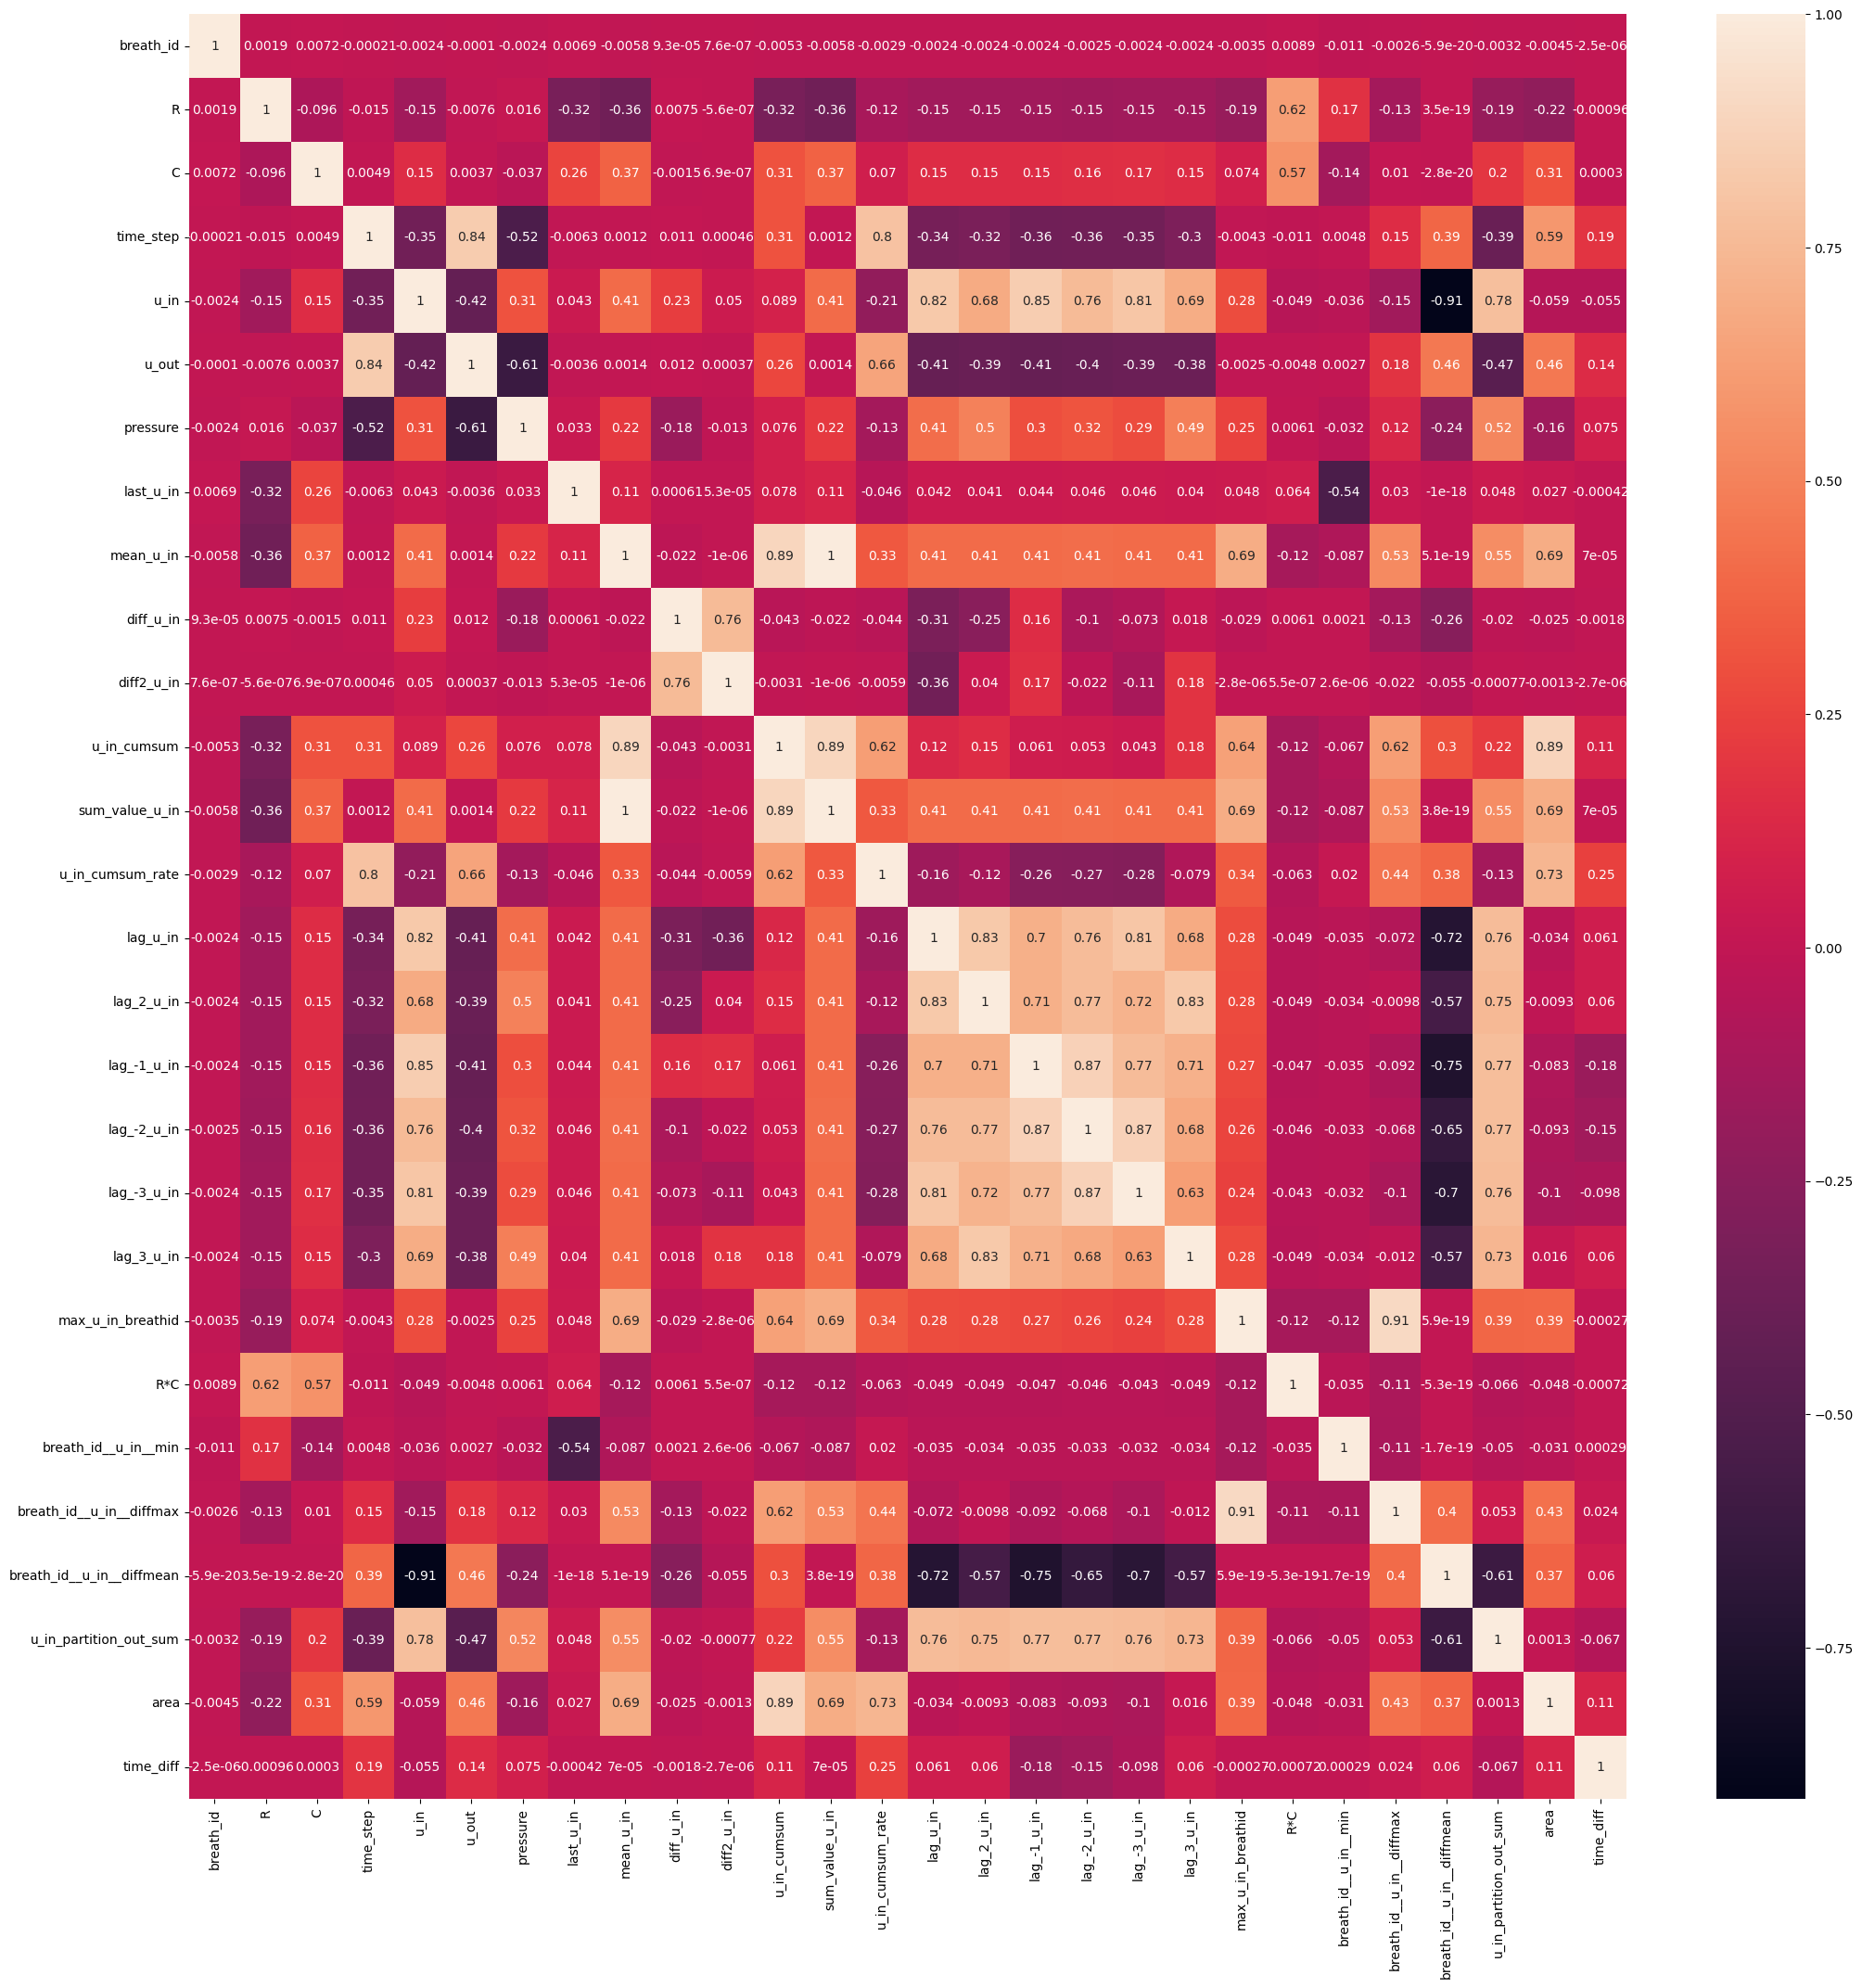

In [64]:
plt.figure(figsize=(25, 25))
fig = sns.heatmap(cor_matrix, annot=True)

# RandomForestRegressor

There are several pairs of highly correlated features: `breath_id__u_in__diffmax`/`max_u_in_breathid`, `mean_u_in`/`sum_value_u_in`,
`breath_id__u_in__diffmean`/`u_in`.

In [65]:
columns_to_drop = ['pressure', 'breath_id', 'mean_u_in', 'max_u_in_breathid', 'breath_id__u_in__diffmax']
X = df.drop(columns_to_drop, axis=1)
y = df.pressure

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

rf = RandomForestRegressor(max_depth=20, n_estimators=19, min_samples_leaf=1, n_jobs=-1)  
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

metrics_values(y_train, y_train_pred, y_test, y_test_pred, 
               'RandomForestRegressor', 
               'RFRegressor{}'.format(rf.get_params()))

RandomForestRegressor(max_depth=20, n_estimators=19, n_jobs=-1)

Train MAPE: 2.650
Test MAPE: 3.342
Train MAE: 0.261
Test MAE: 0.332


Result is much better but model starts to be overfitted.

In [66]:
show_results()

                          Train MAPE	Test MAPE   	Train MAE   	Test MAE    
1. linear regression    : 48.859      	51.714      	3.946       	3.955       
	 {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
2. LinearRegression     : 27.294      	28.819      	2.307       	2.315       
	 PolynomialFeatures{'degree': 6, 'include_bias': False, 'interaction_only': False, 'order': 'C'}
3. Ridge                : 46.749      	48.657      	3.365       	3.371       
	 Ridge{'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'max_iter': 10000, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}
	 PolynomialFeatures{'degree': 6, 'include_bias': False, 'interaction_only': False, 'order': 'C'}
4. RandomForestRegressor: 27.124      	29.403      	2.099       	2.107       
	 RFRegressor{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decre

# Feature importance

In [67]:
# feature importance 
importance_df = pd.DataFrame(rf.feature_importances_, index = X.columns, columns=['value']).sort_values(by='value', ascending=False)
importance_df

,value
time_step,0.464653
u_in_cumsum,0.279739
lag_2_u_in,0.042138
R,0.032262
breath_id__u_in__diffmean,0.029862
C,0.028028
area,0.021707
u_in_partition_out_sum,0.021520
u_in_cumsum_rate,0.019686
R*C,0.015366


Lagest share with `time_step` and `u_in_cumsum` features.

# Hyperparameters

Search for best hyperparameters with Optuna

In [68]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=1)

def optuna_rf(trial):
  
  n_estimators = trial.suggest_int('n_estimators', 15, 50, 5)
  max_depth = trial.suggest_int('max_depth', 10, 20, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)
  
  model = ensemble.RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=1,
                                          n_jobs=-1)
  model.fit(X_train, y_train)
  score = metrics.mean_absolute_percentage_error(y_val, model.predict(X_val))
  return score

study = optuna.create_study(study_name="RandomForestClassifier", direction="minimize")
study.optimize(optuna_rf, n_trials=20)

[I 2025-03-02 00:18:09,110] A new study created in memory with name: RandomForestClassifier
[I 2025-03-02 00:22:37,162] Trial 0 finished with value: 0.044450534593448325 and parameters: {'n_estimators': 40, 'max_depth': 15, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.044450534593448325.
[I 2025-03-02 00:25:51,328] Trial 1 finished with value: 0.03491744982047198 and parameters: {'n_estimators': 25, 'max_depth': 19, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.03491744982047198.
[I 2025-03-02 00:29:15,148] Trial 2 finished with value: 0.03360409663644089 and parameters: {'n_estimators': 25, 'max_depth': 20, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.03360409663644089.
[I 2025-03-02 00:35:50,147] Trial 3 finished with value: 0.03621172189270582 and parameters: {'n_estimators': 50, 'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.03360409663644089.
[I 2025-03-02 00:39:10,081] Trial 4 finished with value: 0.036389456898413164 and paramete

In [82]:
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print("Best Trial: ", study.best_trial)
print("Trials: ", study.trials)

Best params:  {'n_estimators': 25, 'max_depth': 20, 'min_samples_leaf': 3}
Best value:  0.03360409663644089
Best Trial:  FrozenTrial(number=2, state=1, values=[0.03360409663644089], datetime_start=datetime.datetime(2025, 3, 2, 0, 25, 51, 329242), datetime_complete=datetime.datetime(2025, 3, 2, 0, 29, 15, 148369), params={'n_estimators': 25, 'max_depth': 20, 'min_samples_leaf': 3}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=50, log=False, low=15, step=5), 'max_depth': IntDistribution(high=20, log=False, low=10, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=2, value=None)
Trials:  [FrozenTrial(number=0, state=1, values=[0.044450534593448325], datetime_start=datetime.datetime(2025, 3, 2, 0, 18, 9, 111292), datetime_complete=datetime.datetime(2025, 3, 2, 0, 22, 37, 161860), params={'n_estimators': 40, 'max_depth': 15, 'min_samples_leaf': 9}, user_attrs={}, system_attrs={}, intermed

Best parameters are as follows: `n_estimators`: 65, `max_depth`: 17, `min_samples_leaf`: 2

In [70]:
study_df = study.trials_dataframe(attrs=("number", "value", "params", "state"))
study_df.sort_values(by='value', ascending=True)

,number,value,params_max_depth,params_min_samples_leaf,params_n_estimators,state
2,2,0.033604,20,3,25,COMPLETE
14,14,0.033746,20,4,20,COMPLETE
13,13,0.033746,20,4,20,COMPLETE
11,11,0.034065,20,5,15,COMPLETE
12,12,0.034319,20,6,15,COMPLETE
18,18,0.034716,19,4,35,COMPLETE
1,1,0.034917,19,5,25,COMPLETE
3,3,0.036212,18,2,50,COMPLETE
4,4,0.036389,18,4,25,COMPLETE
8,8,0.036818,18,8,25,COMPLETE


In [71]:
# model with the best parameters
rf = RandomForestRegressor(**study.best_params, n_jobs=-1)  
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

metrics_values(y_train, y_train_pred, y_test, y_test_pred, 
               'RandomForestRegressor', 
               'RFRegressor{}\nOptuna best params: {}'.format(rf.get_params(), study.best_params))

RandomForestRegressor(max_depth=20, min_samples_leaf=3, n_estimators=25,
                      n_jobs=-1)

Train MAPE: 2.724
Test MAPE: 3.421
Train MAE: 0.263
Test MAE: 0.340


In [72]:
optuna.visualization.plot_optimization_history(study, target_name="mean_absolute_percentage_error")

In [73]:
optuna.visualization.plot_param_importances(study, target_name="mean_absolute_percentage_error")

`min_samples_leaf` and `n_estimators` features have near zero importance.

With the best parameters model is definitly overfitted. Let's try to change it.

In [ ]:
columns_to_drop = ['pressure', 'breath_id', 'mean_u_in', 'max_u_in_breathid', 'breath_id__u_in__diffmax']
X = df.drop(columns_to_drop, axis=1)
y = df.pressure
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
rf = RandomForestRegressor(max_depth=15, n_estimators=25, n_jobs=-1)  
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

metrics_values(y_train, y_train_pred, y_test, y_test_pred, 
               'RandomForestRegressor', 
               'RFRegressor{}'.format(rf.get_params()))

RandomForestRegressor(max_depth=15, n_estimators=50, n_jobs=-1)

Train MAPE: 4.258
Test MAPE: 4.448
Train MAE: 0.464
Test MAE: 0.482


Result looks much better. In spite of metrics decrease model now is not overfitted. Let this parameters be the best and this model be final.

In [74]:
%%script echo skipping
# save to file for next use
with open("sampler.pkl", "wb") as fout:
    pickle.dump(study.sampler, fout)

skipping


In [75]:
%%script echo skipping
# restore study from file
restored_sampler = pickle.load(open("sampler.pkl", "rb"))
storage = optuna.storages.InMemoryStorage()
study = optuna.create_study(
    study_name='RandomForestClassifier', 
    storage=storage, 
    load_if_exists=True, 
    sampler=restored_sampler
)
study_df = study.trials_dataframe(attrs=("number", "value", "params", "state"))
study_df
# study.optimize(optuna_rf, n_trials=1)

skipping


# Pipeline

In [76]:
# declare custom transformer
class DTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
        time_step_max = X.groupby('breath_id').time_step.idxmax()
        # u_in correspondent to time_step_max
        last_u_in = X.loc[time_step_max, ['breath_id','u_in']]
        # add feature last_u_in
        last_u_in.rename(columns={'u_in':'last_u_in'}, inplace=True)
        X = X.merge(last_u_in, on='breath_id')
        # add feature mean u_in
        mean_u_in = X.groupby('breath_id')['u_in'].mean().to_frame()
        mean_u_in.rename(columns={'u_in':'mean_u_in'}, inplace=True)
        X = X.merge(mean_u_in, on='breath_id')
        X['diff_u_in'] = X.groupby('breath_id')['u_in'].diff()
        X = X.fillna(0)
        X['diff2_u_in'] = X.groupby('breath_id')['diff_u_in'].diff()
        X = X.fillna(0)
        X['u_in_cumsum'] = (X['u_in']).groupby(X['breath_id']).cumsum()
        # add feature sum value u_in
        sum_u_in = X.groupby('breath_id')['u_in'].sum().to_frame()
        sum_u_in.columns = ['sum_value_u_in']
        X = X.merge(sum_u_in,on='breath_id')
        # add feature u_in_cumsum_rate
        X["u_in_cumsum_rate"] = X["u_in_cumsum"] / X["sum_value_u_in"]
        X = X.fillna(0)
        # add feature: lag of u_in
        X['lag_u_in'] = X.groupby('breath_id')['u_in'].shift(1)
        X = X.fillna(0)

        # add feature: lag2 of u_in
        X['lag_2_u_in'] = X.groupby('breath_id')['u_in'].shift(2)
        X = X.fillna(0)
        # add feature lag -1 and -2 u_in
        X['lag_-1_u_in'] = X.groupby('breath_id')['u_in'].shift(-1)
        X = X.fillna(0)

        X['lag_-2_u_in'] = X.groupby('breath_id')['u_in'].shift(-2)
        X = X.fillna(0)
        # add feature lag -3 and 3 u_in
        X['lag_-3_u_in'] = X.groupby('breath_id')['u_in'].shift(-3)
        X = X.fillna(0)

        X['lag_3_u_in'] = X.groupby('breath_id')['u_in'].shift(3)
        X = X.fillna(0)
        # add feature max_u_in_breathid
        X["max_u_in_breathid"] = X.groupby("breath_id")["u_in"].transform("max")

        # add feature R*C
        X["R*C"] = X['R'] * X['C']

        # add breath_id__u_in__min
        X['breath_id__u_in__min'] = X.groupby(['breath_id'])['u_in'].transform('min')

        # add breath_id__u_in__diffmax and breath_id__u_in__diffmean
        X['breath_id__u_in__diffmax'] = X.groupby(['breath_id'])['u_in'].transform('max') - X['u_in']
        X['breath_id__u_in__diffmean'] = X.groupby(['breath_id'])['u_in'].transform('mean') - X['u_in']

        X['u_in_partition_out_sum'] = X.groupby(['breath_id',"u_out"])['u_in'].transform("sum")

        # add feature area
        X['area'] = X['time_step'] * X['u_in']
        X['area'] = X.groupby('breath_id')['area'].cumsum()
        ##add feature time_diff
        X['time_diff']=X.time_step.diff().fillna(0)
        X.drop('breath_id', axis=1, inplace=True)
        return X

In [ ]:
df = pd.read_csv('train.csv')
X = df.drop(['pressure', 'id'], axis=1)
y = df.pressure
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=1)
# {'n_estimators': 19, 'max_depth': 20, 'min_samples_leaf': 3}
pipe = Pipeline([('FeatureEnigneering', DTransformer()), 
                 ('RandomForestRegressor',RandomForestRegressor(max_depth=15, n_estimators=25, n_jobs=-1))])

pipe.fit(X_train, y_train)


Pipeline(steps=[('FeatureEnigneering', DTransformer()),
                ('RandomForestRegressor',
                 RandomForestRegressor(max_depth=20, min_samples_leaf=3,
                                       n_estimators=25, n_jobs=-1))])

In [78]:
# serialize pipeline
# joblib.dump(pipe, 'pipe.joblib')

with open('pipeline.pkl', 'wb') as output:
    pickle.dump(pipe, output)

In [162]:
# del results[:]
# All results recieved so far:
show_results()

                          Train MAPE	Test MAPE   	Train MAE   	Test MAE    
1. RandomForestRegressor: 24.64       	27.581      	1.864       	1.905       
	 RFRegressor{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 15, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 25, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
2. RandomForestRegressor: 4.281       	4.475       	0.467       	0.485       
	 RFRegressor{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 15, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 25, 'n_jobs': -1, 'oob_score': False, 'random_s

# Conclusions

For final model has been chosen demonstrating the best result RandomForestRegressor with next parameters: `n_estimators`: 25, `max_depth`: 15.

Model together with custom transformer is wrapped in pipeline prepared for model deploit. Docker image of the model with means of testing was created and placed on Docker Hub. See `README.md` to know how to use it.